# Всё вместе

## Импорты

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

In [ ]:
! pip install git+https://github.com/yaledhlab/vggface.git
! pip install keras_applications

  Cloning https://github.com/yaledhlab/vggface.git to /tmp/pip-req-build-38f1cjee
  Running command git clone --filter=blob:none --quiet https://github.com/yaledhlab/vggface.git /tmp/pip-req-build-38f1cjee
  Resolved https://github.com/yaledhlab/vggface.git to commit b76539b7588bca69b0030ad7e4f985f877dc7c0a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8331 sha256=79abd6fa4a5650df7a717dfd40ea8f255fa622c1ac07c9e2310f3967b8a07dce
  Stored in directory: /tmp/pip-ephem-wheel-cache-kojq5pwb/wheels/79/35/65/07a23ffb182ac2ec3a43776e08b2cf52daf0ce54da686eefbe
Successfully built keras-vggface
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 623.5 kB/s eta 0:00:00


In [ ]:
from keras_vggface import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Загрузка данных

In [ ]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Нейронная сеть/6_train.csv').sort_values(by='emotion')[['image_path', 'emotion']]
sample_submission = pd.read_csv('/content/drive/My Drive/Нейронная сеть/6_sample_submission.csv')

Mounted at /content/drive


In [ ]:
base_dir = Path('/content/drive/My Drive/Нейронная сеть/')
train = data.iloc[[i for i in range(len(data)) if i%4 != 0]]
valid = data.iloc[[i for i in range(len(data)) if i%4 == 0]]

In [ ]:
def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)

    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface
    """

    preprocessed = utils.preprocess_input(image_, version=2)

    return preprocessed

# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
# train_generator = image_gen.flow_from_dataframe( ... ),
# val_generator = image_gen.flow_from_dataframe( ... )

train_generator = image_gen.flow_from_dataframe(train,
                                                x_col='image_path',
                                                y_col='emotion',
                                                class_mode='categorical',
                                                directory=str(base_dir),
                                                batch_size=BATCH_SIZE,
                                                image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                shuffle=True)


val_generator = image_gen.flow_from_dataframe(valid,
                                              x_col='image_path',
                                              y_col='emotion',
                                              class_mode='categorical',
                                              directory=str(base_dir),
                                              batch_size=BATCH_SIZE,
                                              image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              shuffle=False)

Found 37534 validated image filenames belonging to 9 classes.
Found 12512 validated image filenames belonging to 9 classes.


In [ ]:
label_map = {v:k for k, v in train_generator.class_indices.items()}

## Загрузка модели

In [ ]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
100%|██████████| 166M/166M [00:01<00:00, 88.8MB/s]


'resnet50face.h5'

In [ ]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

In [ ]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)

## Компиляция

In [ ]:
path = Path('/content/drive/My Drive/Нейронная сеть')

path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "checkpoint_emotion_best.h5"
cpt_path = str(path / cpt_filename)

In [ ]:
# base_model.trainable = False
base_model.trainable = True


# fine_tune_at = 100

# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(data['emotion'].nunique(), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='accuracy',
                                                verbose=1, save_best_only=True,
                                                mode='max')

## Обучение

In [ ]:
model = load_model('/content/drive/My Drive/Нейронная сеть/checkpoint_emotion_best.h5')

In [ ]:
model.evaluate

<bound method Model.evaluate of <keras.src.engine.sequential.Sequential object at 0x7c5af016eb30>>

In [ ]:
EPOCHS = 2
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    # validation_data=val_generator,
    callbacks=[checkpoint]
)

Epoch 1/2
25/25 [==============================] - ETA: 0s - loss: 2.1848 - accuracy: 0.4500
Epoch 1: accuracy did not improve from 0.47313
25/25 [==============================] - 118s 5s/step - loss: 2.1848 - accuracy: 0.4500
Epoch 2/2
25/25 [==============================] - ETA: 0s - loss: 2.1481 - accuracy: 0.4613
Epoch 2: accuracy did not improve from 0.47313
25/25 [==============================] - 102s 4s/step - loss: 2.1481 - accuracy: 0.4613


# Проверка

In [ ]:
df_res = pd.DataFrame(columns=['name', 'predict'])

In [ ]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img('/content/drive/My Drive/Нейронная сеть/test_kaggle/4999.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2)

1/1 [==============================] - 2s 2s/step
Predicted: uncertain


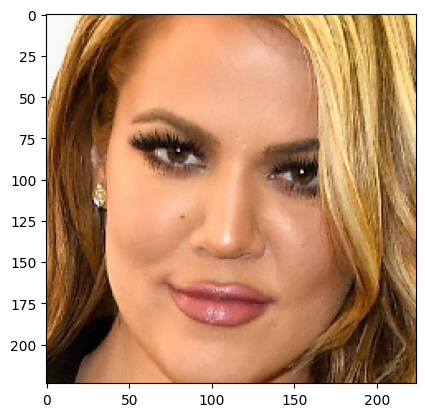

In [ ]:
predicted_labels = model.predict(x)
print(f"Predicted: {label_map[predicted_labels[0].argmax()]}")
plt.imshow(img)

In [ ]:
df_res = df_res.append({'name':'4999.jpg', 'predict': label_map[predicted_labels[0].argmax()]}, ignore_index=True)
df_res

<ipython-input-21-45e3d10ada94>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res = df_res.append({'name':'4999.jpg', 'predict': label_map[predicted_labels[0].argmax()]}, ignore_index=True)


,name,predict
0,4999.jpg,uncertain


In [ ]:
label_map

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

In [ ]:
predicted_labels

array([[1.4861566e-02, 1.7599659e-07, 1.0577752e-07, 1.5980223e-08,
        8.6960190e-06, 8.8510370e-07, 2.0747744e-04, 2.2627867e-07,
        9.8492080e-01]], dtype=float32)

# Итоговый датафрейм

In [ ]:
df_res = pd.DataFrame(columns=['image_path', 'emotion'])

In [ ]:
path = '/content/drive/My Drive/Нейронная сеть/test_kaggle/'
for i in range(0, 5000):
  img = image.load_img('/content/drive/My Drive/Нейронная сеть/test_kaggle/'+ str(i) + '.jpg', target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = utils.preprocess_input(x, version=2)
  # plt.imshow(img)
  predicted_labels = model.predict(x)
  df_res = df_res.append({'name':str(i) + '.jpg', 'predict': label_map[predicted_labels[0].argmax()]}, ignore_index=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_res.head(1)

,image_path,emotion
0,0.jpg,anger


In [ ]:
df_res.to_csv(r' predict.csv', index=False)